In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Dimensionality Reduction

Dimensionality reduction is the process of reducing the number of random variables (features) under consideration. The process of dimensionality reduction has a variety of applications and is used throughout the domain of data mining. Here, we demonstrate dimensionality reduction using PCA and LLE on the Optical Recognition of Handwritten Digits dataset and PCA and *k*-means clustering on the Olivetti faces dataset.

To begin, let's import some libraries we will be needing:

In [2]:
# PCA code modified from authors:
#          Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011

# LLE code modified from author: Fabian Pedregosa <fabian.pedregosa@inria.fr>
# License: BSD 3 clause (C) INRIA 2011

# Eigenfaces code modified from authors:
#          Vlad Niculae
#          Alexandre Gramfort
# License: BSD 3 clause

from time import time

import numpy as np
import pandas as pd
import pylab as pl
from sklearn import (cluster, datasets, decomposition, ensemble, manifold, random_projection)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mpl_toolkits.mplot3d import Axes3D # needed to modify the way figure behaves

Now, let's load the Optical Recognition of Handwritten Digits dataset (hereafter referred to as the "digits" dataset), which is composed of handwritten digits between 0 and 9 stretched into a rectangular 16x16 box. More information on this dataset can found [here](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits). Conveniently, scikit-learn has a predefined function to help us load this dataset. Here, we load 6 classes (the digits 0 through 5), setting the explanatory (or independent or feature) variables as X, and the target (or dependent or class) variable as y.

In [3]:
# Load the digits dataset

digits = datasets.load_digits(n_class=6) # load the dataset with 6 classes (digits 0 through 5)
X = pd.DataFrame(digits.data) # explanatory (or independent or feature) variables
y = pd.Series(digits.target) # target (or dependent or class) variable
n_samples, n_features = X.shape # the number of rows (samples) and columns (features)

Let's see what this dataset looks like. To do this, we transform the rows (which each have 64 features, representing the individual pixels that comprise the image of a digit) into an 8x8 segment of an array, which we then plot as a figure. We do this for the first 400 digits (rows) in the dataset.

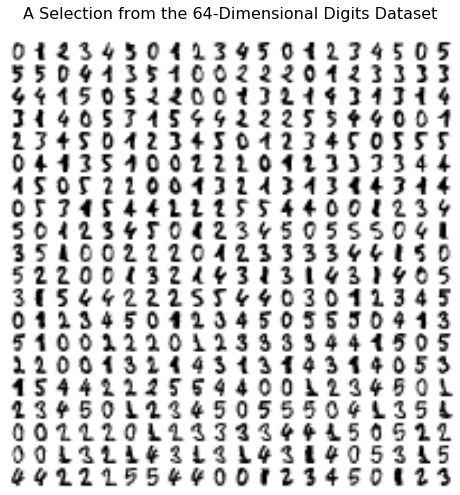

In [4]:
# Plot images of the digits

n_img_per_row = 20 # number of digits per row
img = np.zeros((10*n_img_per_row, 10*n_img_per_row)) # generate a new 200x200 array filled with zeros
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix+8, iy:iy+8] = X.ix[i*n_img_per_row + j].reshape((8, 8)) # set each 8x8 area of the img to the values of each row (reshaped from 1x64 to 8x8)

pl.figure(figsize=(8, 8), dpi=250) # define a figure, with size (width and height) and resolution
axes(frameon = 0) # remove the frame/border from the axes
pl.imshow(img, cmap=pl.cm.binary) # show the image using a binary color map
pl.xticks([]) # no x ticks
pl.yticks([]) # no y ticks
pl.title('A Selection from the 64-Dimensional Digits Dataset\n', fontsize=16)

Now we would like to perform some dimensionality reduction on this dataset and visualize the results of these transformations. We can combine the visualization process for various dimensionality reduction techniques into a single function. The plot embedding function defined below takes care of details related to the visualization of the results of dimensionality reduction techniques when run on the digits dataset. In our visualization, each digit will be displayed using a different color within the reduced feature space.

Generally, PCA requires centering the data (i.e., subtracting the mean from each data point for each feature),  because otherwise the first component may not truly describe the largest direction of variation in the data, but rather the mean of the data.

In [5]:
# Scale and visualize the embedding vectors

def plot_embedding(X, title=None):
    # min-max normalization
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    pl.figure(figsize=(10, 6), dpi=250)
    ax = pl.subplot(111)
    ax.axis('off')
    ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        pl.text(X[i, 0], X[i, 1], str(digits.target[i]), color=pl.cm.Set1(y[i] / 10.), fontdict={'weight': 'bold', 'size': 12})

    if hasattr(matplotlib.offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 5e-3:
                # don't show points that are too close together
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = matplotlib.offsetbox.OffsetImage(digits.images[i], cmap=pl.cm.gray_r, zoom=1.25)
            ab = matplotlib.offsetbox.AnnotationBbox(imagebox, X[i])
            ax.add_artist(ab)
    pl.xticks([]), pl.yticks([])
    pl.ylim([-0.1,1.1])
    pl.xlim([-0.1,1.1])

    if title is not None:
        pl.title(title, fontsize=16)

Now that we have a means of easily visualizing the results of dimensionality reduction, let's generate a random projection of the dataset into fewer dimensions and visualize the results. Here, we are reducing the dataset from 64 features (or dimensions) to 2, and visualizing how similar the digits are to one another when represented by these 2 features. We can generate this projection using a sparse random projection, which projects the original input (feature) space using a sparse random matrix. As a result, we can view the data along 2 new dimensions (or axes), which have been randomly generated. Digits that are closer together in this 2-dimensional space have values that are more similar along these two axes. Note that these 2 axes may not correspond to any of the axes defined by the original 64 features. In other words, each dimension here may be viewed as some combination of the original features.

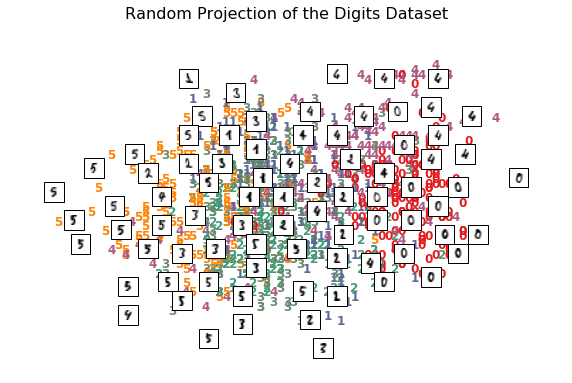

In [6]:
# Random 2D projection using a random unitary matrix

#print("Computing random projection"),
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
#print("done.")

# Plot random projection result
plot_embedding(X_projected, "Random Projection of the Digits Dataset\n")

## Principal Component Analysis (PCA)

Now, let's perform principal component analysis (PCA) to project the data into fewer dimensions. In PCA, the projection is defined by principal components (eigenvectors), each of which can be viewed as a linear combination of the original features that corresponds to a dimension in the projection. The projection is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to (i.e., uncorrelated with) the preceding components. Each principal component (eigenvector) is associated with an eigenvalue, which corresponds to the amount of the variance explained by that component.

Dimensionality reduction is a one-way transformation that induces a loss of information. We can try to minimize the loss of information while retaining the benefits of dimensionality reduction by trying to find the number of principal components needed to effectively represent the original dataset. This number can often be determined by the "elbow" or "knee" point, which is considered to be the natural break between the useful principal components (or dimensions) and residual noise. We can find the elbow point by computing PCA on our dataset and observing the number of principal components after which the amount of variance explained displays a natural break or drop-off.

Since performing PCA on our dataset will generate so many principal components, here we only look at the amount of variance explained by the first 8 components.

In [7]:
# Projection onto the first 8 principal components

# global centering
X_centered = X - X.mean()
    
#print("Computing PCA projection..."),
pca = decomposition.PCA(n_components=8)
X_pca = pca.fit_transform(X_centered)
#print("done.")

print(pca.explained_variance_ratio_)

[ 0.19268752  0.16491423  0.11496179  0.08523838  0.05260764  0.04703754
  0.03596589  0.03111252]


We can generate a bar plot to help visualize these results. More precisely, here our bar plot is considered a scree plot, which graphs the eigenvalue (each of which correspond to an amount of explained variance) against the component number (each of which correspond to a dimension or axis) to help determine an appropriate number of principal components. To determine the appropriate number of components, we look for an "elbow" in the scree plot, the point at which the remaining eigenvalues are relatively small and all about the same size.

In our scree plot, we can see that there is a relatively large drop-off in the explained variance after the second component. We can consider this to be the elbow point. Note that we simply color the bars in the scree plot for aesthetic purposes.

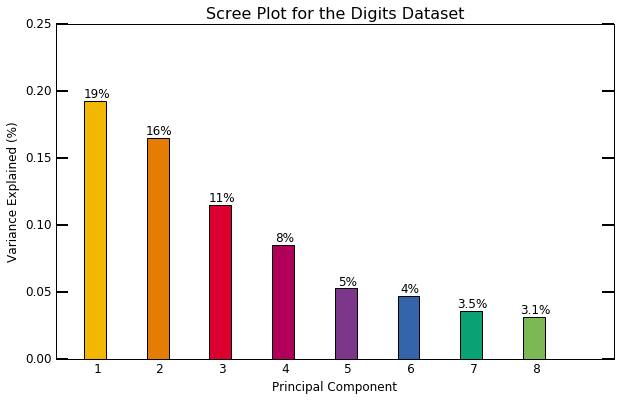

In [8]:
# Generate scree plot

N = 8
ind = np.arange(N)  # the x locations for the groups

vals = [0.19268752,
        0.16491423,
        0.11496179,
        0.08523838,
        0.05260764,
        0.04703754,
        0.03596589,
        0.03111252]

pl.figure(figsize=(10, 6), dpi=250)
ax = pl.subplot(111)
ax.bar(ind, pca.explained_variance_ratio_, 0.35, 
       color=[(0.949, 0.718, 0.004),
              (0.898, 0.49, 0.016),
              (0.863, 0, 0.188),
              (0.694, 0, 0.345),
              (0.486, 0.216, 0.541),
              (0.204, 0.396, 0.667),
              (0.035, 0.635, 0.459),
              (0.486, 0.722, 0.329),
             ])

ax.annotate(r"%d%%" % (int(vals[0]*100)), (ind[0]+0.2, vals[0]), va="bottom", ha="center", fontsize=12)
ax.annotate(r"%d%%" % (int(vals[1]*100)), (ind[1]+0.2, vals[1]), va="bottom", ha="center", fontsize=12)
ax.annotate(r"%d%%" % (int(vals[2]*100)), (ind[2]+0.2, vals[2]), va="bottom", ha="center", fontsize=12)
ax.annotate(r"%d%%" % (int(vals[3]*100)), (ind[3]+0.2, vals[3]), va="bottom", ha="center", fontsize=12)
ax.annotate(r"%d%%" % (int(vals[4]*100)), (ind[4]+0.2, vals[4]), va="bottom", ha="center", fontsize=12)
ax.annotate(r"%d%%" % (int(vals[5]*100)), (ind[5]+0.2, vals[5]), va="bottom", ha="center", fontsize=12)
ax.annotate(r"%s%%" % ((str(vals[6]*100)[:4 + (0-1)])), (ind[6]+0.2, vals[6]), va="bottom", ha="center", fontsize=12)
ax.annotate(r"%s%%" % ((str(vals[7]*100)[:4 + (0-1)])), (ind[7]+0.2, vals[7]), va="bottom", ha="center", fontsize=12)

ax.set_xticklabels(('       0',
                    '       1',
                    '       2',
                    '       3',
                    '       4',
                    '       5',
                    '       6',
                    '       7',
                    '       8'), 
                   fontsize=12)
ax.set_yticklabels(('0.00', '0.05', '0.10', '0.15', '0.20', '0.25'), fontsize=12)
ax.set_ylim(0, .25)
ax.set_xlim(0-0.45, 8+0.45)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component", fontsize=12)
ax.set_ylabel("Variance Explained (%)", fontsize=12)

pl.title("Scree Plot for the Digits Dataset", fontsize=16)

Based upon the scree plot, we can see that retaining 2 components seems appropriate for this dataset. Thus, we can perform PCA again, this time only retaining the top 2 components (alternatively, we could simply remove the remaining components from the original PCA computation). Conveniently, the 2 remaining principal components correspond to 2 dimensions or axes, which we can easily visualize using the plot embedding function we defined previously.

Notice that the 2 dimensions generated by PCA (displayed below) seem to organize the data more effectively than the random projection we initially performed.

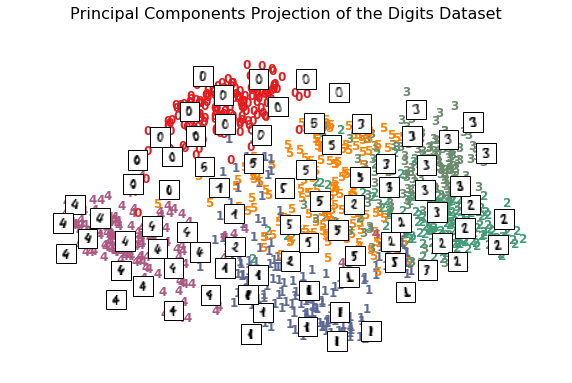

In [9]:
# Compute (two-dimensional) PCA on the digits dataset

#print("Computing PCA projection..."),
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)
#print("done.")

# Plot PCA result
plot_embedding(X_pca, "Principal Components Projection of the Digits Dataset\n")

## Locally Linear Embedding (LLE)

As might be expected, PCA is not the only method for reducing the dimensionality of a dataset. Another popular method we may use to project our dataset into 2 dimensions is known as locally linear embedding (LLE). LLE finds a set of the nearest neighbors of each point, computes a set of weights for each point that best describe the point as a linear combination of its neighbors, and then finds the low-dimensional embedding of points such that each point is still described with the same linear combination of its neighbors. Whereas in PCA each principal component is a straight line along which the data's projections have the most variance, LLE performs a different linear dimensionality reduction at each point (because locally a manifold appears linear) and then combines these linear representations with minimal discrepancy to approximate non-linear structure.

The 2 dimensions generated by LLE (using a set of 30 nearest neighbors for each point) are displayed below. Notice that, given that our digits dataset doesn't have any particular non-linear structure (i.e., the digits are oriented the same way), the organization of the projection doesn't appear to be better (and may even be worse) than that generated by PCA.

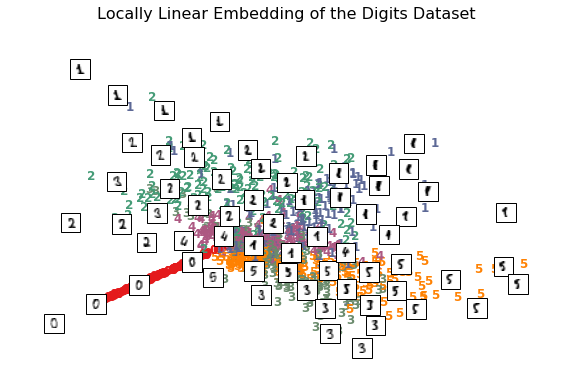

In [10]:
# Compute (two-dimensional) LLE on the digits dataset

#print("Computing LLE..."),
clf = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='standard')
X_lle = clf.fit_transform(X)
#print("done. Reconstruction error: %g" % clf.reconstruction_error_)

# Plot LLE result
plot_embedding(X_lle, "Locally Linear Embedding of the Digits Dataset\n")

Let's see how LLE performs on a dataset with predominantly non-linear structure. Conveniently, scikit-learn provides a function to generate a Swiss roll, a 3-dimensional non-linear dataset that resembles the culinary delight of the same name. Here, we generate a Swiss roll dataset of 1,500 points.

In [11]:
# Generate the Swiss roll

X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500)

We can visualize the Swiss roll dataset using a 3-dimensional figure. 

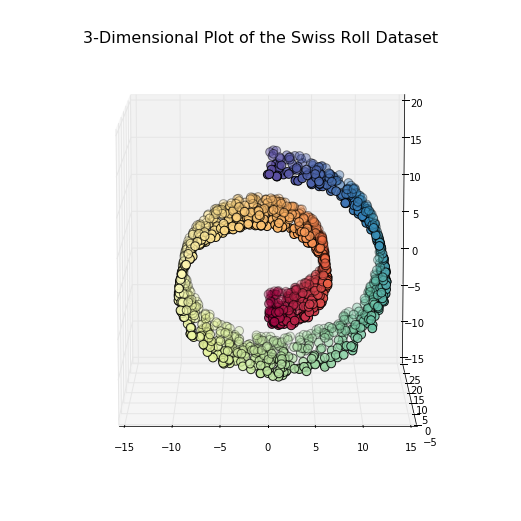

In [12]:
# Plot the Swiss roll

fig = pl.figure(figsize=(10, 20))

# compatibility matplotlib < 1.0
ax = fig.add_subplot(211, projection='3d')
ax.azim = -90
ax.elev = 10
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=75, c=color, cmap=pl.cm.Spectral)

pl.tick_params(axis='both', which='major', labelsize=10)
pl.tick_params(axis='both', which='minor', labelsize=10)

pl.axis('scaled')

pl.title("3-Dimensional Plot of the Swiss Roll Dataset", fontsize=16)

Now we compute LLE on this dataset, retaining just 2 dimensions, which we plot as a figure. Notice how the 3-dimensional structure of the points (that is, similarly-colored points being close together) is maintained by the 2-dimensional LLE projection.

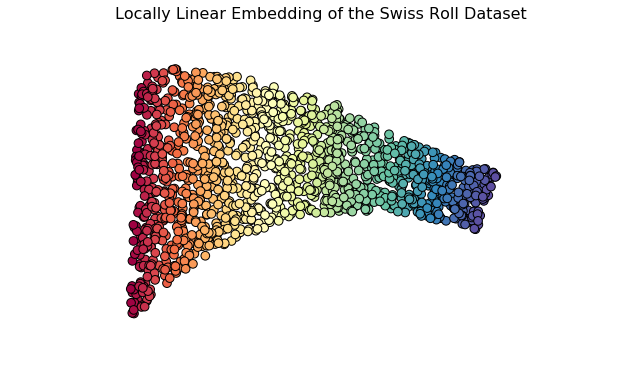

In [13]:
# Compute (two-dimensional) LLE on the Swiss roll dataset

#print("Computing LLE..."),
X_r, err = manifold.locally_linear_embedding(X, n_neighbors=12, n_components=2)
#print("done. Reconstruction error: %g" % err)

# Plot LLE result
fig = pl.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

pl.tick_params(axis='both', which='major', labelsize=10)
pl.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X_r[:, 0], X_r[:, 1], s=75, c=color, cmap=pl.cm.Spectral)
pl.axis('off')

pl.title("Locally Linear Embedding of the Swiss Roll Dataset", fontsize=16)

Now we compute PCA on this dataset, retaining just 2 dimensions, which we plot as a figure. Notice how the 3-dimensional structure of the points (that is, similarly-colored points being close together) is not maintained by the 2-dimensional PCA projection. Instead, the structure is lost, with the points appearing relatively disorganized. This is because PCA cannot account for the non-linear structure (the curvature) of this dataset, whereas LLE can account for this property. You can think of LLE as unraveling the Swiss roll, whereas PCA is flattening the Swiss roll. 

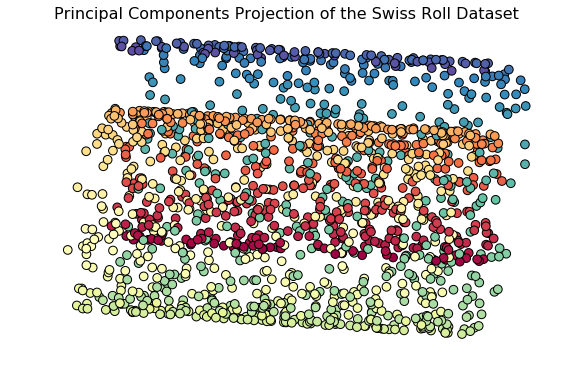

In [14]:
# Compute (two-dimensional) PCA on the Swiss roll dataset

#print("Computing PCA..."),
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
#print("done.")

# Plot PCA result

fig = pl.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

pl.tick_params(axis='both', which='major', labelsize=10)
pl.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X_pca[:, 0], X_pca[:, 1], s=75, c=color, cmap=pl.cm.Spectral)
pl.axis('off')
pl.xticks([]), pl.yticks([])

pl.title("Principal Components Projection of the Swiss Roll Dataset", fontsize=16)

## Using PCA for Computer Vision (Eigenfaces)

So far, we've shown PCA as a way of addressing the curse of dimensionality (the general problems associated with high-dimensional data). However, dimensionality reduction techniques like PCA have more application-specific uses as well.

Consider the computer vision problem of human face recognition. The task of face recognition involves addressing the variation in a collection of face images. Intuitively, we could distinguish between faces by observing how the parts of different faces (facial features) differ. However, this approach can become intractable for large datasets. Fortunately, this is not the only approach.

Eigenfaces refers to an appearance-based approach to face recognition that seeks to capture the variation in a collection of face images and use this information to encode and compare images of individual faces in a holistic manner. In the same way that a set of principal components can represent a set of features, the eigenfaces represent characteristic features of the face images. Any particular face image can be reconstructed from the eigenfaces if one adds up all the eigenfaces (features) in the right proportion. If a particular feature represented by a particular eigenface is present in the original face image to a higher degree, the share of the corresponding eigenface in the "sum" of the eigenfaces should be greater. The reconstructed original face image, then, is equal to a sum of all eigenfaces, with each eigenface having a certain weight. This weight specifies to what degree the specific feature (eigenface) is present in the original face image.

If one uses all the eigenfaces extracted from original face images, one can reconstruct the original images from the eigenfaces exactly. But just like we used only the subset of principal components prior to the elbow point to approximate a dataset, one can also use fewer eigenfaces to generate approximations of the original face images. So in the same way that a smaller set of principal components can represent a larger set of original features, the eigenfaces technique produces dimensionality reduction by using a smaller set of eigenfaces to represent the original face images. Classification, then, can be achieved by comparing how face images are represented by the reduced set of eigenfaces, just as we compared points as represented by the reduced set of principal components.

Conveniently, scikit-learn provides a function to fetch the Olivetti faces dataset, a dataset that contains a set of face images taken between April 1992 and April 1994 at AT&T Laboratories Cambridge. We can use this set of face images to demonstrate the use of eigenfaces.

In [15]:
# Load and normalize faces dataset

n_row, n_col = 2, 3 # the number of rows and columns of faces to display
n_components = n_row * n_col # the number of components to generate
image_shape = (64, 64) # the image dimensions (width and height)

# load faces data
rng = numpy.random.RandomState(0)
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=rng).data

n_samples, n_features = faces.shape # the number of rows (samples) and columns (features)

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces." % n_samples)

Dataset consists of 400 faces.


Next, we can define a function to generate visualizations for the faces.

In [16]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

Now, let's view the first few images in the original dataset, before any preprocessing.

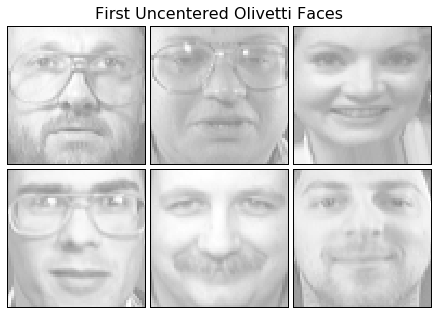

In [17]:
# Plot a sample of the uncentered input data

plot_gallery("First Uncentered Olivetti Faces", faces[:n_components])

Generally, PCA requires centering the data (i.e., subtracting the mean from each data point for each feature),  because otherwise the first component may not truly describe the largest direction of variation in the data, but rather the mean of the data. Below, we show the first few images in the dataset after the data has been centered. The effects of centering the data are clearly visible.

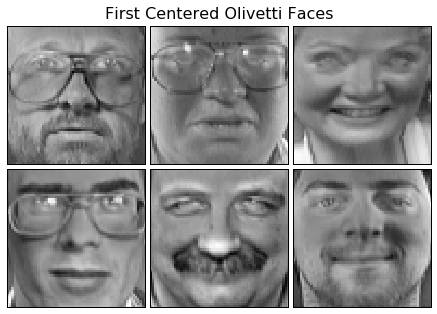

In [18]:
# Plot a sample of the input data

plot_gallery("First Centered Olivetti Faces", faces_centered[:n_components])

Next, we use PCA to generate eigenfaces, which we display below. Here, we generate 6 eigenfaces, which should in combination be able to approximate the original 400 face images in the dataset. Each of these eigenfaces is a linear combination of the features of the original face images.

Extracting the top 6 Eigenfaces - PCA... done in 0.065s


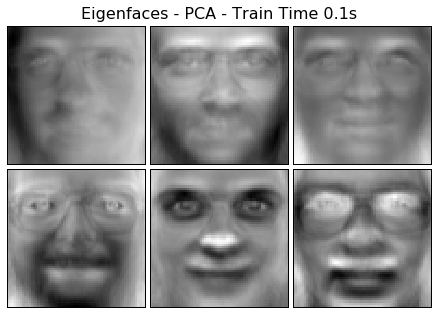

In [19]:
# Compute PCA on the dataset

name = "Eigenfaces - PCA" # estimator name
estimator = decomposition.PCA(n_components=n_components, whiten=True) # estimator
center = True # whether the transformer uses the clustering API

print("Extracting the top %d %s..." % (n_components, name)),
t0 = time()
data = faces
if center:
    data = faces_centered
estimator.fit(data)
train_time = (time() - t0)
print("done in %0.3fs" % train_time)

if hasattr(estimator, 'cluster_centers_'):
    components_ = estimator.cluster_centers_
else:
    components_ = estimator.components_

plot_gallery('%s - Train Time %.1fs' % (name, train_time), components_[:n_components])

Finally, we use (mini batch) *k*-means clustering to generate clusters (or groups) of face images. Here, we generate 6 clusters, which should identify 6 groupings of the original 400 face images in the dataset. We plot the cluster centers below. Clustering the faces using *k*-means accomplishes a goal similar to eigenfaces, but in a different way. We use it here simply as an alternative to the eigenfaces approach by which to illustrate contrasting results.

Extracting the top 6 Cluster Centers - Mini Batch k-Means... done in 0.060s


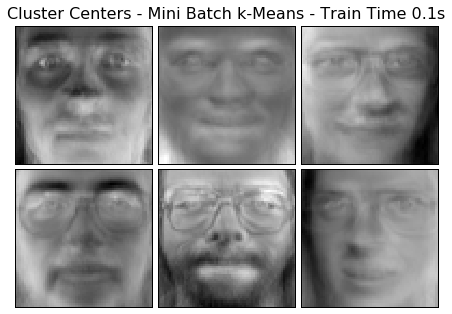

In [20]:
# Compute (mini batch) k-means clustering on the dataset

name = "Cluster Centers - Mini Batch k-Means" # estimator name
estimator = cluster.MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20, max_iter=50, random_state=rng) # estimator
center = True # whether the transformer uses the clustering API

print("Extracting the top %d %s..." % (n_components, name)),
t0 = time()
data = faces
if center:
    data = faces_centered
estimator.fit(data)
train_time = (time() - t0)
print("done in %0.3fs" % train_time)

if hasattr(estimator, 'cluster_centers_'):
    components_ = estimator.cluster_centers_
else:
    components_ = estimator.components_

if hasattr(estimator, 'noise_variance_'):
    plot_gallery("Pixelwise variance", estimator.noise_variance_.reshape(1, -1), n_col=1, n_row=1)
plot_gallery('%s - Train Time %.1fs' % (name, train_time), components_[:n_components])